# Change in labor capacity


The fraction of the total capacity lost is given by

$$
Loss = \tfrac{1}{2}(1+ERF \left( \frac{WBGT-Prod_{mean}}{Prod_{SD} * \sqrt{2}} \right))
$$

Where WBGT is WBGTmax, WBGTmean or WBGThalf.  

| Work level | $Prod_{mean}$ | $Prod_{SD}$ |
|------------|---------------|-------------|
| 200        | 35.53         | 3.94        |
| 300        | 33.49         | 3.94        |
| 400        | 32.47         | 4.16        |



In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from numba import jit
from scipy import stats
from scipy.special import erf
# from math import erf

from tqdm import tnrange, tqdm_notebook
from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC

import population_tools

In [2]:
def labour_loss(wbgt, prod_mean, prod_sd):
    '''
    ..math:
        Loss = (1+ERF((WBGT-Prod_{mean})/(Prod_{SD} * \sqrt{2})))/2

    Args:
         WBGT is WBGTmax, WBGTmean or WBGThalf in Kelvin
         prod_mean is the mean productivity coefficient for a given power level
         prod_sd is the standard deviation coefficient for a given power level
    
    '''
    root2 = 1.4142135623730951 # np.sqrt(2)
    return (1 + erf(((wbgt - 273.15) - prod_mean) / (prod_sd * root2))) / 2



In [3]:
power_level_data = {
    200: (35.53,  3.94),
    300: (33.49, 3.94),
    400: (32.47, 4.16)
    }


MAX_YEAR = 2017
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('./results/lancet2018/global/1.3 labour')

UN_DEMOGRAPHICS_FILE  = POP_DATA_SRC / 'UN' / 'WPP2017_PopulationByAgeSex_Medium.csv'
COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

POP_FILE = POP_DATA_SRC / 'population_count_2000-2020_eightres.nc'

## Plot the labour capacity function

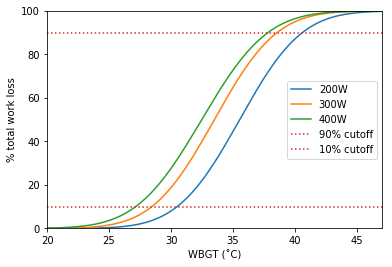

In [4]:
_wbgt = np.arange(20, 47, 0.1) + 273.15
labourcapacity = labour_loss(_wbgt, 35.53, 3.94)
plt.plot(_wbgt - 273.15, labourcapacity * 100, label='200W', color='C0')

labourcapacity = labour_loss(_wbgt, 33.49, 3.94)
plt.plot(_wbgt- 273.15, labourcapacity* 100, label='300W', color='C1')
                             
labourcapacity = labour_loss(_wbgt, 32.47, 4.16)
plt.plot(_wbgt- 273.15, labourcapacity* 100, label='400W', color='C2')

plt.axhline(90, label='90% cutoff', color='C3', linestyle=':')
plt.axhline(10, label='10% cutoff', color='C3', linestyle=':')

plt.legend()


plt.ylim(0, 100)
plt.xlim(20, 47)

plt.xlabel('WBGT (˚C)')
plt.ylabel('% total work loss')

plt.savefig(RESULTS_FOLDER / 'labour_loss_function.png', dpi=300)
plt.savefig(RESULTS_FOLDER / 'labour_loss_function.pdf')

### Plot the clipped version

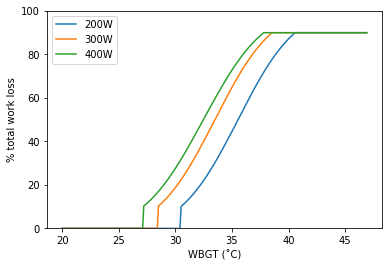

In [11]:
def _clip(lc):
    lc = xr.where(lc < 0.1, 0, lc)
    lc = xr.where(lc > 0.9, 0.9, lc)
    return lc

_wbgt = np.arange(20, 47, 0.1) + 273.15

labourcapacity = labour_loss(_wbgt, 35.53, 3.94)
labourcapacity = _clip(labourcapacity)

plt.plot(_wbgt - 273.15, labourcapacity * 100, label='200W')

labourcapacity = labour_loss(_wbgt, 33.49, 3.94)
labourcapacity = _clip(labourcapacity)
plt.plot(_wbgt- 273.15, labourcapacity* 100, label='300W')

labourcapacity = labour_loss(_wbgt, 32.47, 4.16)
labourcapacity = _clip(labourcapacity)
plt.plot(_wbgt- 273.15, labourcapacity* 100, label='400W')
plt.xlabel('WBGT (˚C)')
plt.ylabel('% total work loss')
plt.ylim(0, 100)
plt.legend()

plt.savefig(RESULTS_FOLDER / 'labour_loss_function_clip.png', dpi=300)

## Apply to WBGT mean, max, half

In [97]:
wbgt_mean = xr.open_mfdataset(
    str(WEATHER_SRC / 'ecmwf' / 'daily_wbgtmean'/ 'wbgt_mean_*.nc'),
    chunks={'time':100}
                             )
wbgt_max = xr.open_mfdataset(
    str(WEATHER_SRC / 'ecmwf' / 'daily_wbgtmax'/ 'wbgt_max_*.nc'),
    chunks={'time':100}
)

wbgt_half = xr.open_mfdataset(
    str(WEATHER_SRC / 'ecmwf' / 'daily_wbgthalf'/ 'wbgt_half_*.nc'),
    chunks={'time':100}
)

In [4]:
def hours_capacity_loss_ufunc(wbgt_mean, wbgt_max, wbgt_half, power_level):
    """
    model hourly WBGT using the 4+4+4 method giving a close approximation 
    to the hourly WBGT during the day. 4 hours per day at WBGTmax, 4 hours 
    at WBGThalf, and 4 hours at WBGTmean.
    
    2 extra conditions:  
    as people take micro-breaks during the hour we assume any work hours
    lost less than 10% is no work hours lost, and as everyone can do at 
    least 6 minutes/hour work even under extreme conditions, we assume 90% 
    work hours lost is a maximum.
    
    """
    power_level_data = {
        200: (35.53,  3.94),
        300: (33.49, 3.94),
        400: (32.47, 4.16)
        }
    
    prod_mean, prod_sd = power_level_data[float(power_level)]
    
    
    # Calculate the labour loss and clip it to the 10%/90%
    # thresholds
    loss_mean = labour_loss(wbgt_mean, prod_mean, prod_sd)
    loss_mean = xr.where(loss_mean < 0.1, 0, loss_mean)
    loss_mean = xr.where(loss_mean > 0.9, 0.9,  loss_mean)
    
    
    loss_max = labour_loss(wbgt_max, prod_mean, prod_sd)
    loss_max = xr.where(loss_max < 0.1, 0, loss_max)
    loss_max = xr.where(loss_max > 0.9, 0.9, loss_max)
    
    
    loss_half = labour_loss(wbgt_half, prod_mean, prod_sd)
    loss_half = xr.where(loss_half < 0.1, 0, loss_half)
    loss_half = xr.where(loss_half > 0.9, 0.9, loss_half)
    
    loss_hours = 4 * loss_mean + 4 * loss_max + 4 * loss_half
    return loss_hours


def save_loss_hours_for_power(power_level):
    loss_hours = xr.apply_ufunc(hours_capacity_loss_ufunc,
                     wbgt_mean.wbgt, wbgt_max.wbgt, wbgt_half.wbgt, power_level,
                     output_dtypes=[np.dtype(wbgt_mean.wbgt)],
                     dask='parallelized'
                    )

    loss_hours.name = 'loss_hours'
    loss_hours = loss_hours.resample(time='1M').sum(dim='time')
    loss_hours = loss_hours.to_dataset()
    years, datasets = zip(*loss_hours.groupby('time.year'))
    paths = [DATA_SRC / 'lancet' / 'labour_capacity' / f'monthly_labour_loss_hours_{power_level}'/ f'loss_hours_{y}.nc' for y in years]
    xr.save_mfdataset(datasets, paths)
        

In [113]:
power_level = 200

save_loss_hours_for_power(power_level)

In [54]:
power_level = 300

save_loss_hours_for_power(power_level)

In [114]:
power_level = 400

save_loss_hours_for_power(power_level)

# Apply the shares of worker activity

In [8]:
UN_DEMOGRAPHICS_TABLE = pd.read_csv(UN_DEMOGRAPHICS_FILE)
# Add the percentages from the population totals
UN_DEMOGRAPHICS_TABLE['PopPct'] = UN_DEMOGRAPHICS_TABLE.groupby(['LocID','Time']).PopTotal.apply(lambda g: g/g.sum())

In [9]:
# Load a country shapefile for rasterising
COUNTRIES = gpd.read_file(str(COUNTRY_SHAPEFILE))
# Translate to match raster coordinates
COUNTRIES.geometry = COUNTRIES.translate(xoff=180)

# Remove missing UN A3 code fields, convert to int and set as index
COUNTRIES.loc[COUNTRIES.un_a3 == '-099', 'un_a3'] = np.nan
COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(float)
COUNTRIES = COUNTRIES[np.isfinite(COUNTRIES.un_a3)]
COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(int)
COUNTRIES = COUNTRIES.set_index('un_a3')

In [10]:
agri = pd.read_excel(DATA_SRC / 'lancet' / 'PopulationERADave.xlsx', 
                     sheet_name='Country-Agemp-to-pop ratio', index_col=0)

indu = pd.read_excel(DATA_SRC / 'lancet' / 'PopulationERADave.xlsx', 
                     sheet_name='Country-Indemp-to-pop ratio', index_col=0)

serv = pd.read_excel(DATA_SRC / 'lancet' / 'PopulationERADave.xlsx', 
                     sheet_name='Country-Servemp-to-pop ratio', index_col=0)

In [11]:
# Tidy up the table and convert the date columns to numbers
agri = agri.drop('Economic activity', axis='columns')
agri.columns = agri.columns.astype(int)

indu = indu.drop('Economic activity', axis='columns')
indu.columns = indu.columns.astype(int)

serv = serv.drop('Economic activity', axis='columns')
serv.columns = serv.columns.astype(int)

In [12]:
# Add country data to sector tables
c = COUNTRIES[['iso_a3', 'iso_n3', 'geometry']]
c = c.reset_index().set_index('iso_a3')

agri = agri.join(c)
indu = indu.join(c)
serv = serv.join(c)

In [13]:
def rasterize_and_save_pct_working_age(year, pop, demographics_table, country_table, out_folder):
    
    select_rows = ((demographics_table.Variant == 'Medium')
                 & (demographics_table.Time == year)
                 & (demographics_table.AgeGrpStart >= 15))
    select_columns = ['LocID', 'PopPct']
    
    demographics = demographics_table.loc[select_rows, select_columns].groupby('LocID').PopPct.sum()
        
    countries = country_table[['geometry']].copy()
    countries['PopPct'] = demographics
    
    raster = population_tools.rasterize_data(pop.population, countries, 'PopPct')
    raster = raster * pop.water_mask.squeeze().values
    raster.shape = (*raster.shape, 1)
    raster = xr.DataArray(raster, coords=[pop.latitude, pop.longitude, [year]], 
                        dims=['latitude', 'longitude', 'year'], name='pct_working_age')

    # For some reason, Panpoly viewer doesn't like 'years' as int64 but accepts int32:/
    raster['year'] = raster['year'].astype(np.int32)

    raster.to_netcdf(str(out_folder / f'pct_working_age_{year}.nc'))

yearly_save_folder = DATA_SRC / 'lancet'/ 'labour_capacity' / 'yearly_pct_working_age'
yearly_save_folder.mkdir(exist_ok=True)

for year in tnrange(2000, MAX_YEAR+1):
    with population_tools.load_masked_population(POP_FILE) as pop_file:
        rasterize_and_save_pct_working_age(year, pop_file, 
                                       UN_DEMOGRAPHICS_TABLE, COUNTRIES, 
                                       yearly_save_folder)


In [14]:
def rasterize_and_save_sector(sector_table, out_folder):
#     pop_file = population_tools.load_masked_population(POP_FILE)
    
    with population_tools.load_masked_population(POP_FILE) as pop_file:
        for year in tnrange(2000, MAX_YEAR+1):
            sector_table = sector_table[~pd.isna(sector_table.geometry)]
            raster = population_tools.rasterize_data(pop_file.population, sector_table, year)
            raster.shape = (*raster.shape, 1)
            raster = xr.DataArray(raster, 
                             coords=[pop_file.latitude, pop_file.longitude, [year]],
                             dims=['latitude', 'longitude', 'year'], name='pct_in_sector')
            
            # For some reason, Panpoly viewer doesn't like 'years' as int64 :/
            raster['year'] = raster['year'].astype(np.int32)
            raster = raster * pop_file.water_mask

            raster.name = 'pct_in_sector'
            raster.to_netcdf(str(out_folder / f'pct_in_sector_{year}.nc'))


In [15]:
yearly_save_folder = DATA_SRC / 'lancet'/ 'labour_capacity' / 'yearly_pct_in_agri'
yearly_save_folder.mkdir(exist_ok=True)

rasterize_and_save_sector(agri, yearly_save_folder)


In [16]:
yearly_save_folder = DATA_SRC / 'lancet'/ 'labour_capacity' / 'yearly_pct_in_indu'
yearly_save_folder.mkdir(exist_ok=True)

rasterize_and_save_sector(indu, yearly_save_folder)


In [17]:
yearly_save_folder = DATA_SRC / 'lancet'/ 'labour_capacity' / 'yearly_pct_in_serv'
yearly_save_folder.mkdir(exist_ok=True)

rasterize_and_save_sector(serv, yearly_save_folder)


# Open the generated datasets and combine

affected population for sector = population * working age fraction * fraction in sector

hours lost for sector = hours lost for power corresponding to sector * affector population for sector

hours lost total = sum of hours lost per sector across all sectors

### Assignment of sectors to work power levels

Once you have the cells proportioned between agriculture, industrial and service then you need to assign work loads to these sectors.  Clearly service sector would (on average) be about 200W and would be on average 300W with some areas (such as construction) going up to 400W, but other areas of industry (maybe clothing manufacture) being near 200W.  Agriculture is a problem, because some of this will be in the sun – which we haven’t quite got refined,  Some will be at 400W (hard work such as digging) while other work might be much less than this (berry or grape picking).  We use 400W in the shade as a ball-park average.


For a first approach, use the following simplified power assignement:


| Sector   | Power (W) |
|----------|-----------|
| Service  | 200       |
| Industry | 300       |
| Agri.    | 400       |     

In [5]:
hours_lost_200 = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'labour_capacity'/ 'monthly_labour_loss_hours_200' / 'loss_hours_*.nc'))
hours_lost_300 = xr.open_mfdataset(str(DATA_SRC / 'lancet'/ 'labour_capacity' / 'monthly_labour_loss_hours_300' / 'loss_hours_*.nc'))
hours_lost_400 = xr.open_mfdataset(str(DATA_SRC / 'lancet'/ 'labour_capacity' / 'monthly_labour_loss_hours_400' / 'loss_hours_*.nc'))

In [6]:
# Calculate the yearly total hours lost for each power level
hours_lost_200 = hours_lost_200.groupby('time.year').sum(dim='time')
hours_lost_300 = hours_lost_300.groupby('time.year').sum(dim='time')
hours_lost_400 = hours_lost_400.groupby('time.year').sum(dim='time')


In [14]:
# Percentages for working age and employment distrubution
pct_working_age = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'labour_capacity' / 'yearly_pct_working_age' / 'pct_working_age_*.nc'))

yearly_pct_in_agri = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'labour_capacity' / 'yearly_pct_in_agri' / 'pct_in_sector_*.nc'))

yearly_pct_in_indu = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'labour_capacity' / 'yearly_pct_in_indu' / 'pct_in_sector_*.nc'))

yearly_pct_in_serv = xr.open_mfdataset(str(DATA_SRC / 'lancet' / 'labour_capacity' / 'yearly_pct_in_serv' / 'pct_in_sector_*.nc'))

### Map plots of loss hours

In [20]:
from cartopy import crs

#### 200W yearly loss hours per cell for 2000 and 2017

In [ ]:
year_vals = hours_lost_200.sel(year=[2000,2017]).loss_hours
year_vals = year_vals.where(year_vals > 0)
year_vals.name = 'Hours lost per person per year'
p = year_vals.plot.pcolormesh(
    col='year',
    cmap='plasma_r',
    transform=crs.PlateCarree(),
    subplot_kws={'projection': crs.Miller()}
                         )
for ax in p.axes.flat:
    ax.coastlines()
    
plt.savefig(RESULTS_FOLDER / '200W 2000 to 2017 comparison.png', 
            bbox_inches='tight', dpi=300)

#### 300W yearly loss hours per cell for 2000 and 2017


In [ ]:
year_vals = hours_lost_300.sel(year=[2000,2017]).loss_hours
year_vals = year_vals.where(year_vals > 0)
year_vals.name = 'Hours lost per person per year'

p = year_vals.plot.pcolormesh(
    vmin=0,
    vmax=700,
    col='year',
    cmap='plasma_r',
    transform=crs.PlateCarree(),
    subplot_kws={'projection': crs.Miller()}
                         )
for ax in p.axes.flat:
    ax.coastlines()
    
plt.savefig(RESULTS_FOLDER / '300W 2000 to 2017 comparison.png', 
            bbox_inches='tight', dpi=300)



#### 400W yearly loss hours per cell for 2000 and 2017


In [ ]:
year_vals = hours_lost_400.sel(year=[2000,2017]).loss_hours
year_vals = year_vals.where(year_vals > 0)
year_vals.name = 'Hours lost per person per year'

p = year_vals.plot.pcolormesh(
    vmin=0,
    vmax=700,
    col='year',
    cmap='plasma_r',
    transform=crs.PlateCarree(),
    subplot_kws={'projection': crs.Miller()}
                         )
for ax in p.axes.flat:
    ax.coastlines()
    
plt.savefig(RESULTS_FOLDER / '400W 2000 to 2017 comparison.png', 
            bbox_inches='tight', dpi=300)

#### Change in labour loss at 400W

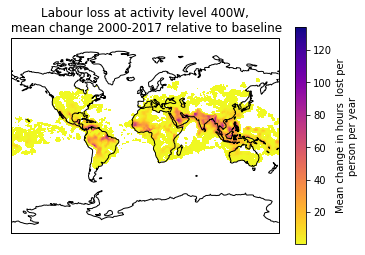

In [21]:
loss_400_baseline = hours_lost_400.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).loss_hours.mean(dim='year')
loss_deltas = hours_lost_400.loss_hours - loss_400_baseline


year_vals = loss_deltas.sel(year=slice(2000,2017)).mean(dim='year')
year_vals = year_vals.where(year_vals > 0)
year_vals.name = 'Mean change in hours \nlost per person per year'

f = plt.figure()
ax = plt.subplot(projection= crs.Miller())
p = year_vals.plot.pcolormesh(
    cmap='plasma_r',
    transform=crs.PlateCarree(),
#     subplot_kws={'projection': crs.Miller()}
                         )
ax.coastlines()
plt.title('Labour loss at activity level 400W,\n mean change 2000-2017 relative to baseline')

#     for ax in p.axes.flat:
    
plt.savefig(RESULTS_FOLDER / '400W 2000 to 2017 mean delta.png', 
            bbox_inches='tight', dpi=600)

plt.savefig(RESULTS_FOLDER / '400W 2000 to 2017 mean delta.pdf', 
            bbox_inches='tight', dpi=600)

### Total loss in hours, not accounting for activity level

In [30]:
hours_lost_total = hours_lost_400 + hours_lost_300 + hours_lost_200

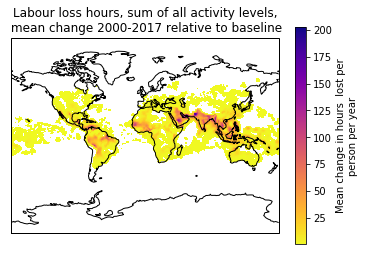

In [31]:
loss_total_baseline = hours_lost_total.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).loss_hours.mean(dim='year')
loss_deltas = hours_lost_total.loss_hours - loss_total_baseline


year_vals = loss_deltas.sel(year=slice(2000,2017)).mean(dim='year')
year_vals = year_vals.where(year_vals > 0)
year_vals.name = 'Mean change in hours \nlost per person per year'

f = plt.figure()
ax = plt.subplot(projection= crs.Miller())
p = year_vals.plot.pcolormesh(
    cmap='plasma_r',
    transform=crs.PlateCarree(),
#     subplot_kws={'projection': crs.Miller()}
                         )
ax.coastlines()
plt.title('Labour loss hours, sum of all activity levels,\n mean change 2000-2017 relative to baseline')

#     for ax in p.axes.flat:
    
plt.savefig(RESULTS_FOLDER / 'total powers 2000 to 2017 mean delta.png', 
            bbox_inches='tight', dpi=300)

## Map the loss hours for each power level onto the corresponding fraction of the population by activity

Map the loss hours for each power level onto the corresponding fraction of the population by activity. This gives the total number of hours of labour lost, being the number of hours lost in a given location per person per sector times the number of people working in that sector, summed across sectors accounting for the different activity levels



In [12]:
# from dask.distributed import Client
# client = Client()
# client

In [13]:
agri_weights = pct_working_age.pct_working_age * yearly_pct_in_agri.pct_in_sector
indu_weights = pct_working_age.pct_working_age * yearly_pct_in_indu.pct_in_sector
serv_weights = pct_working_age.pct_working_age * yearly_pct_in_serv.pct_in_sector

In [27]:
# Project and save the loss hours

# Map population in agriculture to 400W loss hours
agri_map = population_tools.project_to_population(hours_lost_400.loss_hours,
                                                 agri_weights,
                                                  norm=False,
                                                 get_ts=False,
                                                  end_year=MAX_YEAR)

# Map population in industry to 300W loss hours
indu_map = population_tools.project_to_population(hours_lost_300.loss_hours,
                                                 indu_weights, 
                                                 norm=False,
                                                 get_ts=False,
                                                 end_year=MAX_YEAR)

# Map population in service to 200W loss hours
serv_map = population_tools.project_to_population(hours_lost_200.loss_hours,
                                                   serv_weights,
                                                 norm=False,
                                                 get_ts=False,
                                                 end_year=MAX_YEAR)

Combine the loss grids into one dataset and save one file per year

In [29]:
labour_losses = xr.Dataset({'agriculture': agri_map,
            'industry':indu_map,
            'service':serv_map
           })

In [32]:
years, datasets = zip(*labour_losses.groupby('year'))
paths = [DATA_SRC / 'lancet' / 'labour_capacity' / 'labour_capacity_loss'/ f'loss_hours_{y}.nc' for y in years]
xr.save_mfdataset(datasets, paths)

In [36]:
total_loss_sectors = labour_losses.sum(dim=['latitude', 'longitude']).to_dataframe()
total_loss_sectors['total'] = total_loss_sectors.sum(axis=1)

In [45]:
total_loss_sectors.to_excel(RESULTS_FOLDER/'total loss across sectors.xlsx')

Read previously saved results and plot

In [15]:
total_loss_sectors = pd.read_excel(RESULTS_FOLDER/'total loss across sectors.xlsx').set_index('year')

In [16]:
total_loss_sectors.columns = total_loss_sectors.columns.str.capitalize()

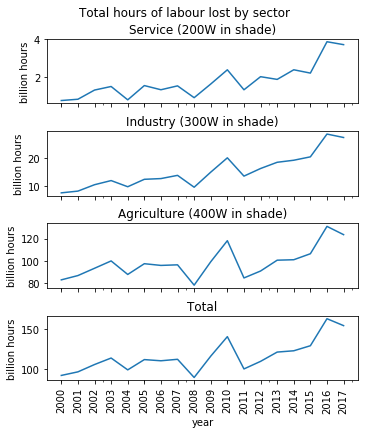

In [17]:
# Get values in billions
t = total_loss_sectors / 1_000_000_000

f, axs = plt.subplots(4,1, constrained_layout=True, sharex=True)
f.set_size_inches(5,6)
f.suptitle('Total hours of labour lost by sector')
ax = axs[0]
t.Service.plot(ax=ax)
ax.set_title('Service (200W in shade)')
ax.set_xlabel('')
ax.set_ylabel('billion hours')

ax = axs[1]
t.Industry.plot(ax=ax)
ax.set_title('Industry (300W in shade)')
ax.set_xlabel('')
ax.set_ylabel('billion hours')

ax = axs[2]
t.Agriculture.plot(ax=ax)
ax.set_title('Agriculture (400W in shade)')
ax.set_ylabel('billion hours')

ax = axs[3]
t.Total.plot(ax=ax)
ax.set_title('Total')
ax.set_ylabel('billion hours')

plt.xticks(total_loss_sectors.index, rotation=90);

plt.savefig(RESULTS_FOLDER / 'total_labour_loss_by_sector.png', bbox_inches='tight', dpi=300)
plt.savefig(RESULTS_FOLDER / 'total_labour_loss_by_sector.pdf', bbox_inches='tight')

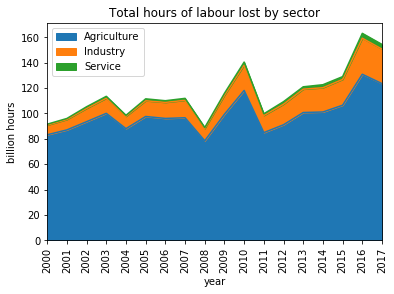

In [18]:
t = total_loss_sectors / 1_000_000_000
ax = t[['Agriculture', 'Industry', 'Service']].plot.area()
ax.set_ylabel('billion hours')

plt.title('Total hours of labour lost by sector')
plt.xlim(2000, 2017)
plt.xticks(t.index, rotation=90);
plt.savefig(RESULTS_FOLDER / 'total_labour_loss_by_sector_area.png', bbox_inches='tight', dpi=300)
plt.savefig(RESULTS_FOLDER / 'total_labour_loss_by_sector_area.pdf', bbox_inches='tight')

